In [3]:

import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import power_transform, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from paretoset import paretoset
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter


import argparse
from pathlib import Path
import logging

logger = logging.getLogger(__name__)

In [4]:

FOLDER = Path("output/plots/")
csv_file = FOLDER / "data.csv"
data = pd.read_csv(csv_file, index_col=0)
data.head()

,stage,attack,data,files,kwargs,model,name,scorers,train_time,train_time_per_sample,...,model_name,random_state,def_param,def_value,atk_param,atk_value,adv_failures_per_training_time,adv_failure_rate,failure_rate,failures_per_training_time
0,attack,art.attacks.evasion.PixelAttack,000e900bad53681aa2468550956e6f09,000e900bad53681aa2468550956e6f09,000e900bad53681aa2468550956e6f09,000e900bad53681aa2468550956e6f09,000e900bad53681aa2468550956e6f09,000e900bad53681aa2468550956e6f09,66.816678,0.001193,...,ResNet50,5,scale,1.000000,th,0.011765,NaN,NaN,NaN,NaN
1,attack,art.attacks.evasion.PixelAttack,001c1b378bbfe5942ca63cfb22d745b8,001c1b378bbfe5942ca63cfb22d745b8,001c1b378bbfe5942ca63cfb22d745b8,001c1b378bbfe5942ca63cfb22d745b8,001c1b378bbfe5942ca63cfb22d745b8,001c1b378bbfe5942ca63cfb22d745b8,NaN,NaN,...,ResNet18,2,bit_depth,0.066667,th,0.000000,NaN,NaN,NaN,NaN
2,attack,art.attacks.evasion.CarliniL0Method,001ddff47c0ad0926affea2b3cfafe86,001ddff47c0ad0926affea2b3cfafe86,001ddff47c0ad0926affea2b3cfafe86,001ddff47c0ad0926affea2b3cfafe86,001ddff47c0ad0926affea2b3cfafe86,001ddff47c0ad0926affea2b3cfafe86,99.405136,0.001775,...,ResNet18,5,NaN,NaN,confidence,0.000000,NaN,NaN,NaN,NaN
3,attack,art.attacks.evasion.FastGradientMethod,0022118d46ac791faba90c6f907516f0,0022118d46ac791faba90c6f907516f0,0022118d46ac791faba90c6f907516f0,0022118d46ac791faba90c6f907516f0,0022118d46ac791faba90c6f907516f0,0022118d46ac791faba90c6f907516f0,203.195971,0.003628,...,ResNet34,7,NaN,NaN,eps,0.123905,0.412329,0.000526,0.000044,0.458764
4,attack,art.attacks.evasion.DeepFool,0036b069268b81ebc05519c3372608b9,0036b069268b81ebc05519c3372608b9,0036b069268b81ebc05519c3372608b9,0036b069268b81ebc05519c3372608b9,0036b069268b81ebc05519c3372608b9,0036b069268b81ebc05519c3372608b9,46.047791,0.000822,...,ResNet34,9,NaN,NaN,nb_grads,1.000000,0.094515,0.011601,0.000015,0.082228


In [5]:
def plot_aft(data,  file, event_col, duration_col, title, mtype,  xlabel="$\log(\eta)$ - 95% CI", ylabel = "Covariate", replacement_dict={}, **kwargs):
    if mtype == 'weibull':
        aft = WeibullAFTFitter(**kwargs)
    elif mtype == 'log_normal':
        aft = LogNormalAFTFitter(**kwargs)
    elif mtype == 'log_logistic':
        aft = LogLogisticAFTFitter(**kwargs)
    df, test = train_test_split(data, test_size=.2, random_state=42)
    assert duration_col in df.columns, f"Column {duration_col} not in dataframe with columns {df.columns}"
    assert event_col in df.columns, f"Column {event_col} not in dataframe with columns {df.columns}"
    aft.fit(df, duration_col=duration_col, event_col=event_col)
    aft.fit(df, duration_col=duration_col, event_col=event_col)
    ax = aft.plot()
    ax.set_ylabel(ylabel)
    labels = ax.get_yticklabels()
    labels = [label.get_text() for label in labels]
    for k,v in replacement_dict.items():
        labels = [ label.replace(k, v) for label in labels]
    ax.set_yticklabels(labels)
    ax.set_xlabel(xlabel);
    ax.set_title(title);
    ax.get_figure().tight_layout()
    ax.get_figure().savefig(FOLDER / file)
    logger.info(f"Saved graph to {FOLDER / file}")
    return ax, aft


def clean_data_for_aft(data, kwarg_list, standard_scaling=True,  target='adv_failure_rate'):
    subset = data.copy()
    y = subset[target].copy(deep=True)
    cleaned = pd.DataFrame()
    if target in kwarg_list:
        kwarg_list.remove(target)
    for kwarg in kwarg_list:
        cleaned = pd.concat([cleaned, subset[kwarg]], axis=1)
    cols = cleaned.columns
    if standard_scaling is True:
        scaler = StandardScaler()
        scaler = scaler.fit(cleaned)
        cleaned_numeric = pd.DataFrame(scaler.transform(cleaned), columns=cols)
    else:
        cleaned_numeric = cleaned
    
    cleaned_numeric = pd.DataFrame(subset, columns=cols)
    cleaned_numeric.def_value.fillna(0, inplace=True)
    # replace 0 with 1e-6
    # cleaned_numeric = cleaned_numeric.replace(0, replace_0)
    return cleaned_numeric, y


In [6]:
kwarg_list = [
        "accuracy",
        "train_time",
        "atk_value",
        "def_value",
        "adv_fit_time",
        "random_state",
        "adv_failure_rate",
        "predict_time",
        # "adv_fit_time",
        # "adv_accuracy",
        # "adv_fit_time_per_sample",
        # "adv_accuracy",
    ]


cleaned, y = clean_data_for_aft(data, kwarg_list, standard_scaling=True)
cleaned.dropna(axis = 0, how = 'any', subset=kwarg_list.remove("def_value"), inplace=True)
cleaned['adv_failure_rate'] = y
    


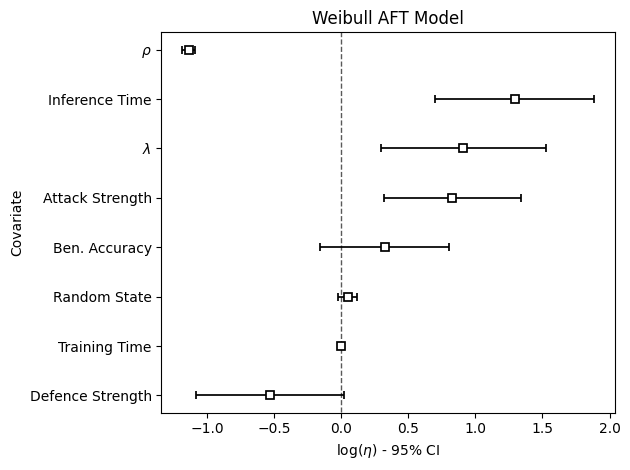

In [7]:
weibull_dict = {
        "Intercept: rho_" : "$\\rho$",
        "Intercept: lambda_" : "$\lambda$",
        "random_state: lambda_" : "Random State",
        "def_value: lambda_" : "Defence Strength",
        "atk_value: lambda_" : "Attack Strength",
        "train_time: lambda_" : "Training Time",
        "predict_time: lambda_" : "Inference Time",
        "accuracy: lambda_" : "Ben. Accuracy",
    }

weibull_graph, wft = plot_aft(cleaned, "weibull_aft.pdf", "adv_failure_rate", "adv_fit_time", "Weibull AFT Model", 'weibull', replacement_dict=weibull_dict)
    

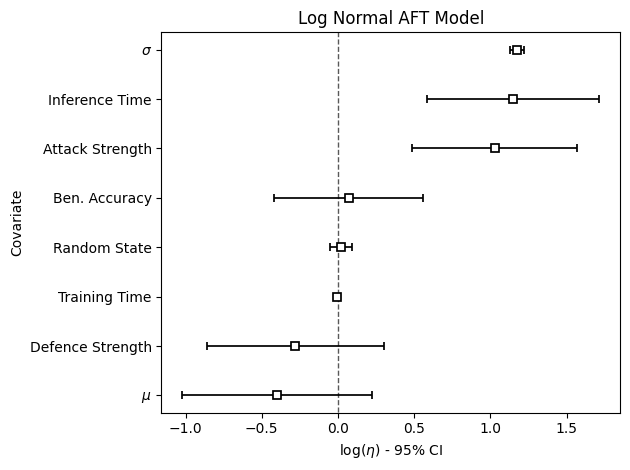

In [8]:
log_normal_dict = {
        "Intercept: sigma_" : "$\sigma$",
        "Intercept: mu_" : "$\mu$",
        "random_state: mu_" : "Random State",
        "def_value: mu_" : "Defence Strength",
        "atk_value: mu_" : "Attack Strength",
        "train_time: mu_" : "Training Time",
        "predict_time: mu_" : "Inference Time",
        "accuracy: mu_" : "Ben. Accuracy",
        "adv_fit_time: mu_" : "Adv. Fit Time",
    }
    
log_normal_graph, lnt = plot_aft(cleaned, "log_normal_aft.pdf", "adv_failure_rate", "adv_fit_time", "Log Normal AFT Model", 'log_normal', replacement_dict=log_normal_dict)

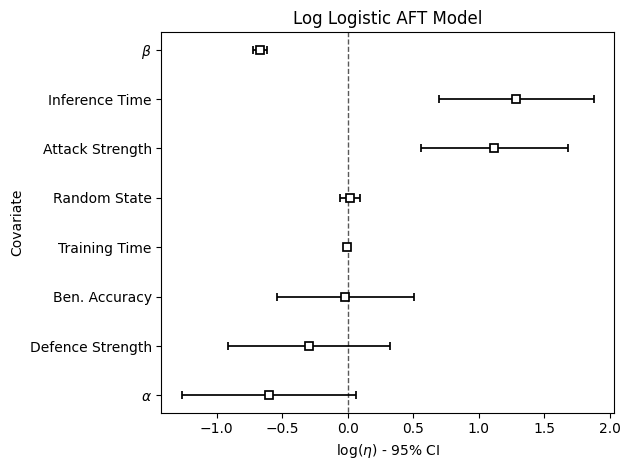

In [9]:
log_logistic_dict = {
        "Intercept: beta_" : "$\\beta$",
        "Intercept: alpha_" : "$\\alpha$",
        "random_state: alpha_" : "Random State",
        "def_value: alpha_" : "Defence Strength",
        "atk_value: alpha_" : "Attack Strength",
        "train_time: alpha_" : "Training Time",
        "predict_time: alpha_" : "Inference Time",
        "accuracy: alpha_" : "Ben. Accuracy",
        "adv_fit_time: alpha_" : "Adv. Fit Time",
    }
    
log_logistic_graph, llt = plot_aft(cleaned, "log_logistic_aft.pdf", "adv_failure_rate", "adv_fit_time", "Log Logistic AFT Model", 'log_logistic', replacement_dict=log_logistic_dict)


In [10]:
aft_dict = {
    "Weibull" : wft,
    "LogNormal" : lnt,
    "LogLogistic" : llt,
}
aft_data = pd.DataFrame()
aft_data.index.name = "Model"
aft_data.index = aft_dict.keys()
aft_data['AIC'] = [x.AIC_ for x in aft_dict.values()]
aft_data['LogLikelihood'] = [x.log_likelihood_ for x in aft_dict.values()]
aft_data['Concordance Score'] = [x.concordance_index_ for x in aft_dict.values()]
aft_data['BIC'] = [x.BIC_ for x in aft_dict.values()]
aft_data = aft_data.round(2)
aft_data.to_csv(FOLDER / "aft_comparison.csv")
logger.info(f"Saved AFT comparison to {FOLDER / 'aft_comparison.csv'}")